In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/SAPIENZA/CV/Project/RoadObstaceDetection

[Errno 2] No such file or directory: '/content/drive/MyDrive/SAPIENZA/CV/Project/RoadObstaceDetection'
/content


In [ ]:
#Installs the segmentation-models-pytorch library used for DeepLabV3+
!pip install -U segmentation-models-pytorch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import segmentation_models_pytorch as smp
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2
import random
from scipy.ndimage import binary_opening, binary_closing, binary_dilation


In [ ]:
#Maps fine-grained Cityscapes/LostAndFound labels to 7 macro-classes
CITYSCAPES_LABELIDS_TO_GROUP = {

    0: 0,      # road
    1: 1, 2: 1,                   # sidewalk, parking -> flat
    3: 4, 4: 4, 5: 4, 6: 4, 7: 4, # building, wall, fence, guard rail, bridge -> construction
    8: 5, 9: 5, 10: 5,            # pole, traffic light, traffic sign -> object
    11: 2, 12: 2,                 # person, rider -> human
    13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, # car, truck, bus, caravan, trailer, train -> vehicle
    19: 6, 20: 6, 21: 6, 22: 6, 23: 6, 24: 6, 255: 6, # sky, ground, static, dynamic, water, terrain, unlabeled -> background
    40:5, 41:5, 42:5

}


In [ ]:

class MappedObstacleDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.img_paths = []
        self.mask_paths = []
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        for city in os.listdir(img_dir):
            city_img_dir = os.path.join(img_dir, city)
            city_mask_dir = os.path.join(mask_dir, city)
            if not os.path.isdir(city_img_dir): continue
            for fname in os.listdir(city_img_dir):
                if fname.endswith("_leftImg8bit.png"):
                    img_path = os.path.join(city_img_dir, fname)
                    mask_name = fname.replace("_leftImg8bit.png", "_gtCoarse_labelIds.png")
                    mask_path = os.path.join(city_mask_dir, mask_name)
                    if os.path.exists(mask_path):
                        self.img_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        mask = np.array(Image.open(self.mask_paths[idx]))  # Cityscapes labelIds

        # Mapping
        macro_mask = np.vectorize(lambda x: CITYSCAPES_LABELIDS_TO_GROUP.get(x, 255))(mask).astype(np.int64)


        macro_mask = torch.from_numpy(macro_mask).long()

        # OBJECTNESS: 1 where macroclass == 2,3,4,5 ("object"), 0 elsewhere
        object_mask = ((macro_mask == 2)| (macro_mask == 3) | (macro_mask == 4) | (macro_mask == 5)).long()

        # Transforms
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
           print("📏 object_mask shape:", object_mask.shape, "dtype:", object_mask.dtype)

           # Convert to numpy uint8 before PIL conversion
           object_mask_np = object_mask.numpy().astype(np.uint8) * 255
           object_mask_pil = Image.fromarray(object_mask_np)
           object_mask = self.mask_transform(object_mask_pil).squeeze(0)

           macro_mask = self.mask_transform(Image.fromarray(macro_mask.numpy().astype(np.uint8) * 32)).squeeze(0)

        return {
            "image": image,
            "class_mask": macro_mask,
            "object_mask": object_mask
        }

resize_dims = (512, 1024)
img_transform = T.Compose([
    T.Resize(resize_dims),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# ===  Transforms  ===
mask_transform = T.Compose([
    T.Resize((512, 1024), interpolation=T.InterpolationMode.NEAREST),
    T.ToTensor(),  # Convert to tensor [1, H, W] float32 ∈ [0, 1]
    T.Lambda(lambda x: (x > 0.5).long())  # Binarization→ 0 o 1, type long
])
# == DATASET/LOADER == #
img_dir = "/content/drive/MyDrive/SAPIENZA/CV/Project/RoadObstacleDetection/Datasets/LostAndFound/leftImg8bit/test"
mask_dir = "/content/drive/MyDrive/SAPIENZA/CV/Project/RoadObstacleDetection/Datasets/LostAndFound/gtCoarse/test"

test_dataset = MappedObstacleDataset(
    img_dir=img_dir,
    mask_dir=mask_dir,
    img_transform=img_transform,
    mask_transform=mask_transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
class DeepLabDualHead(nn.Module):
    def __init__(self, n_classes=7):
        super().__init__()
        self.base = smp.DeepLabV3Plus(
            encoder_name="resnet50",
            encoder_weights="imagenet",
            in_channels=3,
            classes=n_classes
        )
        self.base.classifier = nn.Identity()

        self.head_softmax = nn.Conv2d(256, n_classes, kernel_size=1)
        self.head_sigmoid = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.base.encoder(x)
        decoder_output = self.base.decoder(features)
        softmax_output = self.head_softmax(decoder_output)
        sigmoid_output = self.head_sigmoid(decoder_output)
        return softmax_output, sigmoid_output



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabDualHead(n_classes=7)
model.load_state_dict(torch.load("/content/drive/MyDrive/SAPIENZA/CV/Project/RoadObstacleDetection/ProjectWorkspace/ckpts/updated_loss_model.pth", map_location=device))
model = model.eval().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:

# Applies thresholding and morphological filtering to a UOS map.
# Filters small blobs, removes overly large components, and optionally dilates valid predictions to cover full obstacles.

# Applies adaptive or fixed thresholding to the UOS map,
# followed by morphological operations to clean small noisy regions
# and remove overly large connected components (non-obstacles).
# Optionally, it performs morphological dilation to extend the predicted blobs,
# making the obstacle masks more complete (especially useful for small or fragmented detections).

def filter_and_threshold(uos_map, adaptive=True, threshold=0.1, top_percent=0.02,
                         open_size=1, close_size=2, max_area_ratio=0.03,
                         dilate=True, dilate_size=5):
    if adaptive:
        thresh = np.quantile(uos_map, 1 - top_percent)
    else:
        thresh = threshold

    bin_mask = uos_map > thresh

    # Morphology
    bin_mask = binary_opening(bin_mask, structure=np.ones((open_size, open_size)))
    bin_mask = binary_closing(bin_mask, structure=np.ones((close_size, close_size)))

    # Remove too big components
    bin_mask_uint8 = (bin_mask * 255).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(bin_mask_uint8, connectivity=8)

    H, W = uos_map.shape
    max_area = max_area_ratio * H * W
    clean_mask = np.zeros_like(bin_mask_uint8)

    for i in range(1, num_labels):  # 0 = background
        area = stats[i, cv2.CC_STAT_AREA]
        if area <= max_area:
            clean_mask[labels == i] = 1

    # Dilation to extend detected blobs
    if dilate:
        clean_mask = binary_dilation(clean_mask, structure=np.ones((dilate_size, dilate_size))).astype(np.uint8)

    return clean_mask

# Visualizes a few random predictions from the dataset using UOS maps.
# Applies uncertainty and objectness thresholds, filtering, and creates overlay visualizations against the ground truth.
def visualize_random_predictions2(model, dataset, device,
                                 lambda_hat=0.6, obj_thresh=0.1, top_percent=0.02,
                                 num_samples=4, adaptive=True):
    model.eval()
    model.to(device)

    with torch.no_grad():
        rand_indices = random.sample(range(len(dataset)), num_samples)
        batch = [dataset[i] for i in rand_indices]

        images = torch.stack([item["image"] for item in batch]).to(device)
        targets = torch.stack([item["object_mask"] for item in batch])

        # Forward step
        softmax_output, sigmoid_output = model(images)
        class_probs = torch.softmax(softmax_output, dim=1)
        objectness = sigmoid_output.squeeze(1)
        max_probs = class_probs.max(dim=1)[0]
        nonconf = 1.0 - max_probs

        uncertainty_mask = (nonconf > lambda_hat).float()
        object_mask = (objectness > obj_thresh).float()
        uos_map = (uncertainty_mask * object_mask).cpu().numpy()

        for i in range(images.size(0)):
            if targets[i].sum() == 0:
                continue

            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img = np.clip(img, 0, 1)
            img_uint8 = (img * 255).astype(np.uint8)

            gt_mask = targets[i].cpu().numpy()
            uos_pred = uos_map[i]

            # UOS filter with dilation
            pred_mask = filter_and_threshold(
                uos_pred,
                adaptive=adaptive,
                top_percent=top_percent,
                open_size=1,
                close_size=2,
                max_area_ratio=0.05,
                dilate=True,             #  dilation enabling
                dilate_size=4           #  kernel 5x5 (can actually change)
            )

            H, W = img_uint8.shape[:2]
            gt_resized = cv2.resize(gt_mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
            pred_resized = cv2.resize(pred_mask, (W, H), interpolation=cv2.INTER_NEAREST)

            # Overlay
            overlay = np.zeros_like(img_uint8)
            overlay[gt_resized == 1] = [255, 0, 0]
            overlay[pred_resized == 1] = [0, 255, 0]
            overlay[(gt_resized == 1) & (pred_resized == 1)] = [255, 255, 0]
            blended = cv2.addWeighted(img_uint8, 1.0, overlay, 0.5, 0)

            # Plot
            plt.figure(figsize=(20, 5))
            plt.subplot(1, 5, 1); plt.imshow(img); plt.title("Image"); plt.axis('off')
            plt.subplot(1, 5, 2); plt.imshow(gt_resized, cmap='gray'); plt.title("GT Obstacle"); plt.axis('off')
            plt.subplot(1, 5, 3); plt.imshow(objectness[i].cpu(), cmap='hot'); plt.title("Objectness"); plt.axis('off')
            plt.subplot(1, 5, 4); plt.imshow(uos_pred, cmap='hot'); plt.title("UOS map"); plt.axis('off')
            plt.subplot(1, 5, 5); plt.imshow(blended); plt.title("Overlay"); plt.axis('off')
            plt.tight_layout()
            plt.show()


📏 object_mask shape: torch.Size([1024, 2048]) dtype: torch.int64
📏 object_mask shape: torch.Size([1024, 2048]) dtype: torch.int64
📏 object_mask shape: torch.Size([1024, 2048]) dtype: torch.int64
📏 object_mask shape: torch.Size([1024, 2048]) dtype: torch.int64


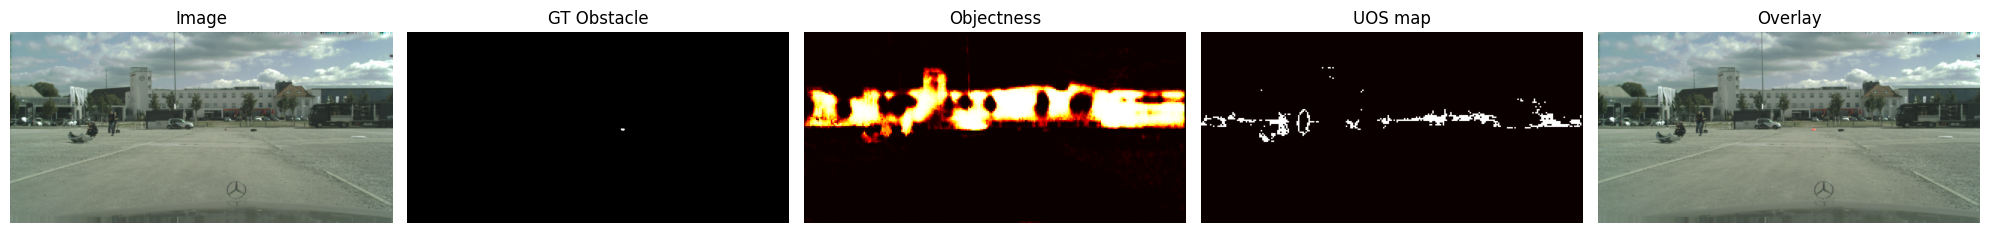

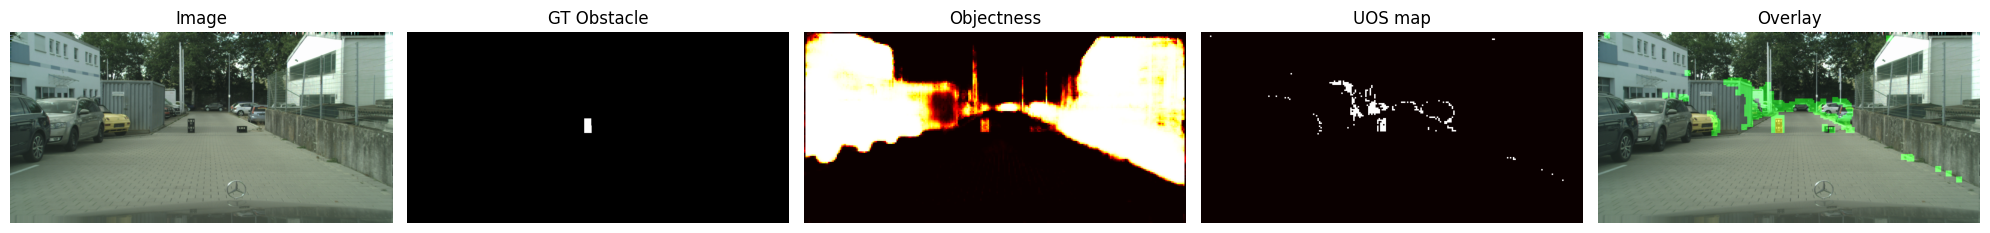

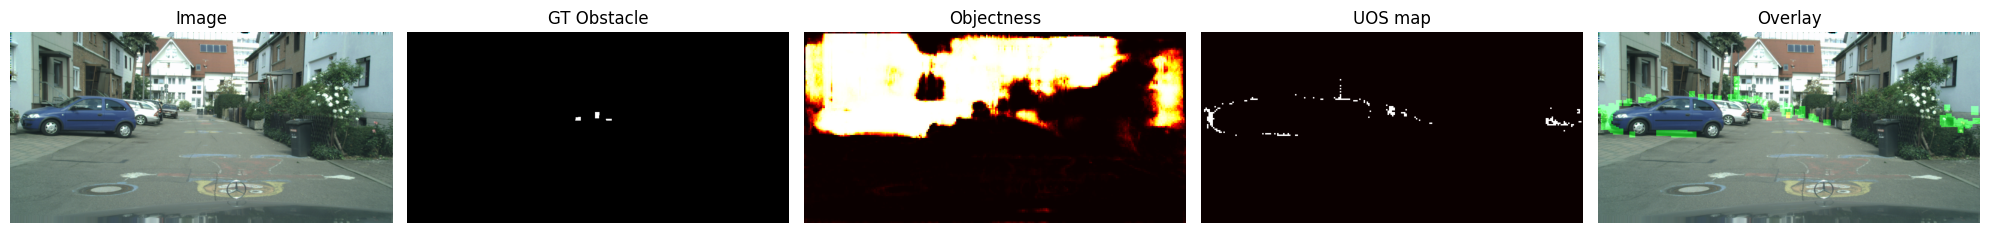

In [ ]:
visualize_random_predictions2(
    model,
    dataset=test_loader.dataset,
    device=device,
    lambda_hat=0.6,
    obj_thresh=0.2,
    top_percent=0.02,
    num_samples=4,
    adaptive=True
)


In [ ]:
# Performs a grid search over lambda_hat and objectness threshold values.
# For each combination, evaluates prediction performance and saves results in a CSV file for comparison.
def analyze_metrics_grid(model,
                         dataset,
                         device,
                         lambda_values=[0.2, 0.3, 0.4, 0.5, 0.6],
                         obj_thresh_values=[0.1, 0.2, 0.3, 0.4, 0.5],
                         max_images=5,
                         save_dir="grid_search_results"):

    os.makedirs(save_dir, exist_ok=True)
    results = []

    for lambda_hat in tqdm(lambda_values, desc="λ sweep"):
        for obj_thresh in obj_thresh_values:
            try:
                print(f"\n🔍 Testing λ={lambda_hat}, obj_thresh={obj_thresh}")
                result_df = analyze_uos_predictions(
                    model=model,
                    dataset=dataset,
                    device=device,
                    lambda_hat=lambda_hat,
                    obj_thresh=obj_thresh,
                    max_images=max_images,
                    save_dir=os.path.join(save_dir, f"lambda_{lambda_hat}_obj_{obj_thresh}")
                )

                precision_mean = result_df["Precision"].mean()
                recall_mean = result_df["Recall"].mean()
                iou_mean = result_df["IoU"].mean()

                results.append({
                    "lambda_hat": lambda_hat,
                    "obj_thresh": obj_thresh,
                    "Precision": precision_mean,
                    "Recall": recall_mean,
                    "IoU": iou_mean
                })

            except Exception as e:
                print(f"⚠️ Error at λ={lambda_hat}, obj_thresh={obj_thresh}: {e}")
                results.append({
                    "lambda_hat": lambda_hat,
                    "obj_thresh": obj_thresh,
                    "Precision": None,
                    "Recall": None,
                    "IoU": None
                })

    df = pd.DataFrame(results)
    csv_path = os.path.join(save_dir, "grid_metrics.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n Grid search results saved to: {csv_path}")
    return df


In [ ]:
grid_results_df, grid_results_csv = analyze_metrics_grid(
    model=model,
    dataset=test_loader.dataset,
    device=device,
    lambda_values=[0.2, 0.3, 0.4, 0.5, 0.6],
    obj_thresh_values=[0.1, 0.2, 0.3, 0.4, 0.5],
    max_images=100,
    save_dir="/mnt/data/grid_search_results"
    )


In [ ]:
# Full evaluation using UOS maps with adaptive thresholding and morphological filtering (including dilation).
# Computes pixel-wise metrics, generates visualization maps, and saves per-image results and global summary.
def analyze_uos_predictions_filtered(model, dataset, device,
                                     lambda_hat=0.6, obj_thresh=0.1, top_percent=0.05,
                                     adaptive=True,
                                     open_size=1, close_size=2, max_area_ratio=0.05,
                                     dilate=True, dilate_size=4,
                                     save_dir="uos_eval_filtered"):

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, "overlays"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "maps"), exist_ok=True)

    model.eval()
    model.to(device)

    all_preds, all_targets, metrics = [], [], []

    with torch.no_grad():
        for idx in tqdm(range(len(dataset))):
            sample = dataset[idx]
            image = sample["image"].unsqueeze(0).to(device)
            gt_mask = sample["object_mask"].numpy()

            softmax_output, sigmoid_output = model(image)
            class_probs = torch.softmax(softmax_output, dim=1)
            objectness = sigmoid_output.squeeze(1)
            max_probs = class_probs.max(dim=1)[0]
            nonconf = 1.0 - max_probs

            uncertainty_mask = (nonconf > lambda_hat).float()
            object_mask = (objectness > obj_thresh).float()
            uos_map = (uncertainty_mask * object_mask).cpu().numpy()[0]

            pred_mask = filter_and_threshold(
                uos_map,
                adaptive=adaptive,
                top_percent=top_percent,
                threshold=0.1,
                open_size=open_size,
                close_size=close_size,
                max_area_ratio=max_area_ratio,
                dilate=dilate,
                dilate_size=dilate_size
            )

            img_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img_np = np.clip(img_np, 0, 1)
            img_uint8 = (img_np * 255).astype(np.uint8)

            gt_resized = cv2.resize(gt_mask.astype(np.uint8), (img_uint8.shape[1], img_uint8.shape[0]), interpolation=cv2.INTER_NEAREST)
            pred_resized = cv2.resize(pred_mask.astype(np.uint8), (img_uint8.shape[1], img_uint8.shape[0]), interpolation=cv2.INTER_NEAREST)

            # pixel-wise metrics
            intersection = np.logical_and(gt_resized == 1, pred_resized == 1).sum()
            union = np.logical_or(gt_resized == 1, pred_resized == 1).sum()
            gt_area = (gt_resized == 1).sum()
            pred_area = (pred_resized == 1).sum()

            precision = intersection / (pred_area + 1e-6)
            recall = intersection / (gt_area + 1e-6)
            iou = intersection / (union + 1e-6)

            metrics.append({
                "image_id": idx,
                "GT_pixels": int(gt_area),
                "UOS_pixels": int(pred_area),
                "TP": int(intersection),
                "Precision": precision,
                "Recall": recall,
                "IoU": iou
            })

            all_preds.append(pred_resized.flatten())
            all_targets.append(gt_resized.flatten())

            # Overlay
            overlay = np.zeros_like(img_uint8)
            overlay[gt_resized > 0] = [255, 0, 0]
            overlay[pred_resized > 0] = [0, 255, 0]
            overlay[(gt_resized > 0) & (pred_resized > 0)] = [255, 255, 0]
            blended = cv2.addWeighted(img_uint8, 1.0, overlay, 0.5, 0)

            cv2.imwrite(os.path.join(save_dir, "overlays", f"{idx:03d}_overlay.png"), blended[..., ::-1])
            plt.imsave(os.path.join(save_dir, "maps", f"{idx:03d}_uos_raw.png"), uos_map, cmap="hot")
            plt.imsave(os.path.join(save_dir, "maps", f"{idx:03d}_uos_mask.png"), pred_resized, cmap="gray")

    # Save CSV
    df = pd.DataFrame(metrics)
    df.to_csv(os.path.join(save_dir, "metrics.csv"), index=False)

    # Global metrics
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    try:
        auroc = roc_auc_score(all_targets, all_preds)
        ap = average_precision_score(all_targets, all_preds)
        precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_preds)
        fpr95 = 1 - precision_curve[np.argmin(np.abs(recall_curve - 0.95))] if any(recall_curve >= 0.95) else None
    except Exception as e:
        auroc, ap, fpr95 = None, None, None
        print(f" AUROC/AP error: {e}")

    tp_total = df["TP"].sum()
    gt_total = df["GT_pixels"].sum()
    pred_total = df["UOS_pixels"].sum()

    precision_global = tp_total / (pred_total + 1e-6)
    recall_global = tp_total / (gt_total + 1e-6)
    iou_global = tp_total / (gt_total + pred_total - tp_total + 1e-6)

    summary = {
        "AUROC": auroc,
        "AveragePrecision": ap,
        "FPR@95TPR": fpr95,
        "GlobalPrecision": precision_global,
        "GlobalRecall": recall_global,
        "GlobalIoU": iou_global,
        "NumImages": len(df),
        "NumWithGT": int((df["GT_pixels"] > 0).sum()),
        "NumZeroTP": int((df["TP"] == 0).sum()),
        "NumOnlyFP": int(((df["GT_pixels"] == 0) & (df["UOS_pixels"] > 0)).sum())
    }

    with open(os.path.join(save_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=4)

    print(f"\n Saved metrics to: {save_dir}/metrics.csv and summary.json")
    return df, summary


In [ ]:
df, summary = analyze_uos_predictions_filtered(
    model=model,
    dataset=test_loader.dataset,
    device=device,
    lambda_hat=0.6,
    obj_thresh=0.1,
    top_percent=0.05,
    adaptive=True,
    open_size=1,
    close_size=2,
    max_area_ratio=0.05,
    dilate=True,
    dilate_size=4,
    save_dir="uos_eval_filtered"
)
